# TCC - NIDS Distribuido

> Tarefa:
Testar 4 Classificadores nos 5 NetFlow V2 Datasets em https://staff.itee.uq.edu.au/marius/NIDS_datasets/#RA6

- [X] Matrix de Confusão
- [X] Curva ROC
- [X] Comparar Classificadores

## Datasets


### General Characteristics

Feature | Description
---|---
IPV4_SRC_ADDR | IPv4 source address
IPV4_DST_ADDR | IPv4 destination address
L4_SRC_PORT | IPv4 source port number
L4_DST_PORT | IPv4 destination port number
PROTOCOL | IP protocol identifier byte
L7_PROTO | Layer 7 protocol (numeric)
IN_BYTES | Incoming number of bytes
OUT_BYTES | Outgoing number of bytes
IN_PKTS | Incoming number of packets
OUT_PKTS | Outgoing number of packets
FLOW_DURATION_MILLISECONDS | Flow duration in milliseconds
TCP_FLAGS | Cumulative of all TCP flags
CLIENT_TCP_FLAGS | Cumulative of all client TCP flags
SERVER_TCP_FLAGS | Cumulative of all server TCP flags
DURATION_IN | Client to Server stream duration (msec)
DURATION_OUT | Client to Server stream duration (msec)
MIN_TTL | Min flow TTL
MAX_TTL | Max flow TTL
LONGEST_FLOW_PKT | Longest packet (bytes) of the flow
SHORTEST_FLOW_PKT | Shortest packet (bytes) of the flow
MIN_IP_PKT_LEN | Len of the smallest flow IP packet observed
MAX_IP_PKT_LEN | Len of the largest flow IP packet observed
SRC_TO_DST_SECOND_BYTES | Src to dst Bytes/sec
DST_TO_SRC_SECOND_BYTES | Dst to src Bytes/sec
RETRANSMITTED_IN_BYTES | Number of retransmitted TCP flow bytes (src->dst)
RETRANSMITTED_IN_PKTS | Number of retransmitted TCP flow packets (src->dst)
RETRANSMITTED_OUT_BYTES | Number of retransmitted TCP flow bytes (dst->src)
RETRANSMITTED_OUT_PKTS | Number of retransmitted TCP flow packets (dst->src)
SRC_TO_DST_AVG_THROUGHPUT | Src to dst average thpt (bps)
DST_TO_SRC_AVG_THROUGHPUT | Dst to src average thpt (bps)
NUM_PKTS_UP_TO_128_BYTES | Packets whose IP size <= 128
NUM_PKTS_128_TO_256_BYTES | Packets whose IP size > 128 and <= 256
NUM_PKTS_256_TO_512_BYTES | Packets whose IP size > 256 and <= 512
NUM_PKTS_512_TO_1024_BYTES | Packets whose IP size > 512 and <= 1024
NUM_PKTS_1024_TO_1514_BYTES | Packets whose IP size >  1024 and <= 1514
TCP_WIN_MAX_IN | Max TCP Window (src->dst)
TCP_WIN_MAX_OUT | Max TCP Window (dst->src)
ICMP_TYPE | ICMP Type * 256 + ICMP code
ICMP_IPV4_TYPE | ICMP Type
DNS_QUERY_ID | DNS query transaction Id
DNS_QUERY_TYPE | "DNS query type (e.g. 1=A, 2=NS..)"
DNS_TTL_ANSWER | TTL of the first A record (if any)
FTP_COMMAND_RET_CODE | FTP client command return code


### NF-UNSW-NB15-v2

The publicly available pcaps of the ToN-IoT dataset are utilised to generate its NetFlow records, leading to a NetFlow-based IoT network dataset called NF-ToN-IoT. The total number of data flows is 16,940,496 out of which 10,841,027 (63.99%) are attack samples and 6,099,469 (36.01%), the table below lists and defines the distribution of the NF-ToN-IoT-v2 dataset.

Class |	Count |	Description
--- | --- | ---
Benign	| 2295222 |	Normal unmalicious flows
Fuzzers |	22310 |	An attack in which the attacker sends large amounts of random data which cause a system to crash and also aim to discover security vulnerabilities in a system.
Analysis |	2299 |	A group that presents a variety of threats that target web applications through ports, emails and scripts.
Backdoor |	2169 |	A technique that aims to bypass security mechanisms by replying to specific constructed client applications.
DoS	| 5794 | Denial of Service is an attempt to overload a computer system's resources with the aimof preventing access to or availability of its data.
Exploits |	31551 |	Are sequences of commands controlling the behaviour of a host through a known vulnerability
Generic | 16560 | A method that targets cryptography and causes a collision with each block-cipher.
Reconnaissance | 12779 |	A technique for gathering information about a network host and is also known as a probe.
Shellcode |	1427 |	A malware that penetrates a code to control a victim's host.
Worms |164 | Attacks that replicate themselves and spread to other computers.

### NF-BoT-IoT-v2


An IoT NetFlow-based dataset was generated by expanding the NF-BoT-IoT dataset. The features were extracted from the publicly available pcap files and the flows were labelled with their respective attack categories. The total number of data flows is 37,763,497 out of which 37,628,460 (99.64%) are attack samples and 135,037 (0.36%) are benign. There are four attack categories in the dataset, the table below represents the NF-BoT-IoT-v2 distribution of all flows.

Class | Count | Description
---|---|---
Benign | 135037 | Normal unmalicious flows
Reconnaissance | 2620999 | A technique for gathering information about a network host and is also known as a probe.
DDoS | 18331847 | Distributed Denial of Service is an attempt similar to DoS but has multiple different distributed sources.
DoS | 16673183 | An attempt to overload a computer system's resources with the aim of preventing access to or availability of its data.
Theft | 2431 | A group of attacks that aims to obtain sensitive data such as data theft and keylogging

## Imports

In [ ]:
#@title #### Install

SHOULD_INSTALL = False

if SHOULD_INSTALL:
    !pip install numpy
    !pip install heatmapz
    !pip install pandas
    !pip install seaborn
    !pip install matplotlib
    !pip install scikit-learn

In [ ]:
import os
import platform
import random
import requests
import subprocess

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from heatmap import heatmap, corrplot
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression, chi2

## Functions

In [ ]:
def plot_ROC(y, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    #plt.plot(fpr, tpr, label=f"data 1, auc={auc_score}")
    #plt.legend(loc=4)
    plt.show()

datasets_source = {
    "NF-UNSW-NB15-v2": "https://github.com/vmsou/BCC-TCC/raw/master/datasets/NF-UNSW-NB15-v2.zip",
    "NF-ToN-IoT-v2": "https://github.com/vmsou/BCC-TCC/raw/master/datasets/NF-ToN-IoT-v2.zip",
    "NF-BoT-IoT-v2": "https://github.com/vmsou/BCC-TCC/raw/master/datasets/NF-BoT-IoT-v2.zip",
    "NF-CSE-CIC-IDS2018-v2": "https://github.com/vmsou/BCC-TCC/raw/master/datasets/NF-CSE-CIC-IDS2018-v2.zip",
    "NF-UQ-NIDS-v2": "https://github.com/vmsou/BCC-TCC/raw/master/datasets/NF-UQ-NIDS-v2.zip"
}


def download_dataset(dataset: str) -> None:
    # Check if dataset already exists
    if os.path.exists(f"datasets/{dataset}.csv"):
        print("Dataset already downloaded.")
        return

    # else: Check if zip already exists
    if os.path.exists(f"datasets/{dataset}.zip"):
        print("Compressed file already downloaded.")
    else:
        print(f"Downloading {dataset}.zip... ", end='')
        r = requests.get(datasets_source[dataset])
        os.makedirs("datasets", exist_ok=True)
        with open(f"datasets/{dataset}.zip", 'wb') as f:
            f.write(r.content)
        print("OK")

    # then: unzip compressed if exists
    print(f"Extracting datasets/{dataset}.zip... ", end='')
    os.makedirs("datasets", exist_ok=True)
    subprocess.run(["unzip", "-o", f"datasets/{dataset}.zip", "-d", "datasets"])
    print("OK")

## Settings

In [ ]:
#@markdown <h4>Dataset</h4> <hr>
DATASET = "NF-UNSW-NB15-v2" #@param ["NF-UNSW-NB15-v2", "NF-ToN-IoT-v2", "NF-BoT-IoT-v2", "NF-CSE-CIC-IDS2018-v2", "NF-UQ-NIDS-v2"]
TARGET = "Label" #@param {type: "string"}
RANDOM_SEED = 42 #@param {type: "number"}

#@markdown <h4>Application</h4> <hr>
USE_DT = True #@param {type:"boolean"}
DT_ARGS_RAW = "dict(random_state=RANDOM_SEED)" #@param {type:"string"}
# DT_ARGS_RAW = dict(max_depth=range(1, 11), min_samples_split=range(2, 7), criterion=["entropy", "gini",], splitter=["best", "random"], max_features=["sqrt", "log2", None], ccp_alpha=[0.1, 0.01], random_state=[RANDOM_SEED])
DT_ARGS = eval(DT_ARGS_RAW)

USE_KNN = True #@param {type:"boolean"}
KNN_ARGS_RAW = "dict(n_neighbors=3)" #@param {type:"string"}
# KNN_ARGS_RAW = dict(n_neighbors=range(1, 6), weights=["uniform", "distance"], p=[1, 2], algorithm=['ball_tree', 'kd_tree', 'brute'])
KNN_ARGS = eval(KNN_ARGS_RAW)

USE_SVM = True #@param {type:"boolean"}
SVM_ARGS_RAW = "dict(random_state=RANDOM_SEED)" #@param {type:"string"}
# SVM_ARGS_RAW = dict(C=[0.1, 10, 100], kernel=["rbf", "sigmoid"], gamma=["scale", 1, 0.1, 0.01], random_state=[RANDOM_SEED])
SVM_ARGS = eval(SVM_ARGS_RAW)

USE_NB = True #@param {type:"boolean"}
NB_ARGS_RAW = "dict()" #@param {type:"string"}
NB_ARGS = eval(NB_ARGS_RAW)

#@markdown #### Cross Validation <hr/>
USE_CV = False #@param {type: "boolean"}
USE_GRIDSEARCH = False #@param {type: "boolean"}
FOLDS = 2 #@param {type:"slider", min:1, max:5, step:1}
N_JOBS = 15 # @param {type:"slider", min:-1, max:16, step:1}
TRAIN_SIZE = 0.8 #@param {type:"slider", min:0, max:1, step:0.1}

os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Show every column
pd.set_option('display.max_columns', None)

## Dataset

In [ ]:
#@title #### Load
download_dataset(DATASET)
data = pd.read_csv(f"datasets/{DATASET}.csv")
target_names = data[TARGET].unique()
print("Dataset has been loaded")

Dataset already downloaded.
Dataset has been loaded


In [ ]:
#@title #### Sample
data.head(5)

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,59.166.0.5,1305,149.171.126.8,21,6,1.0,9,1,193,3,24,24,16,0,0,0,31,32,89,52,52,89,456.0,435.0,0,0,0,0,3648000,3480000,15,0,0,0,0,0,7240,0,0,0,0,0,331.0,0,Benign
1,59.166.0.5,1305,149.171.126.8,21,6,1.0,261,5,469,7,24,24,24,0,0,0,31,32,89,52,52,89,708.0,711.0,74,1,89,1,4656000,4584000,23,0,0,0,0,8688,8688,18944,74,0,0,0,230.0,0,Benign
2,59.166.0.5,1305,149.171.126.8,21,6,1.0,481,9,750,11,24,24,24,0,0,0,31,32,94,52,52,94,928.0,992.0,132,2,172,2,5576000,5696000,31,0,0,0,0,10136,10136,33792,132,0,0,0,229.0,0,Benign
3,59.166.0.5,1305,149.171.126.8,21,6,1.0,701,13,1054,15,24,24,24,0,0,0,31,32,106,52,52,106,1148.0,1296.0,190,3,266,3,6480000,6864000,39,0,0,0,0,11584,11584,48640,190,0,0,0,125.0,0,Benign
4,59.166.0.5,1305,149.171.126.8,21,6,1.0,1031,19,1474,21,24,24,24,0,0,0,31,32,106,52,52,106,1478.0,1716.0,251,4,437,5,7544000,8240000,51,0,0,0,0,14480,13032,64256,251,0,0,0,230.0,0,Benign


## General Characteristics

In [ ]:
#@title #### Columns and Types

data.dtypes

IPV4_SRC_ADDR                   object
L4_SRC_PORT                      int64
IPV4_DST_ADDR                   object
L4_DST_PORT                      int64
PROTOCOL                         int64
L7_PROTO                       float64
IN_BYTES                         int64
IN_PKTS                          int64
OUT_BYTES                        int64
OUT_PKTS                         int64
TCP_FLAGS                        int64
CLIENT_TCP_FLAGS                 int64
SERVER_TCP_FLAGS                 int64
FLOW_DURATION_MILLISECONDS       int64
DURATION_IN                      int64
DURATION_OUT                     int64
MIN_TTL                          int64
MAX_TTL                          int64
LONGEST_FLOW_PKT                 int64
SHORTEST_FLOW_PKT                int64
MIN_IP_PKT_LEN                   int64
MAX_IP_PKT_LEN                   int64
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int64
RETRANSMITTED_IN_PKTS    

In [ ]:
#@title #### Number of instances
display(len(data))

2390275

In [ ]:
#@title #### Number of features
display(len(data.columns) - 1)

44

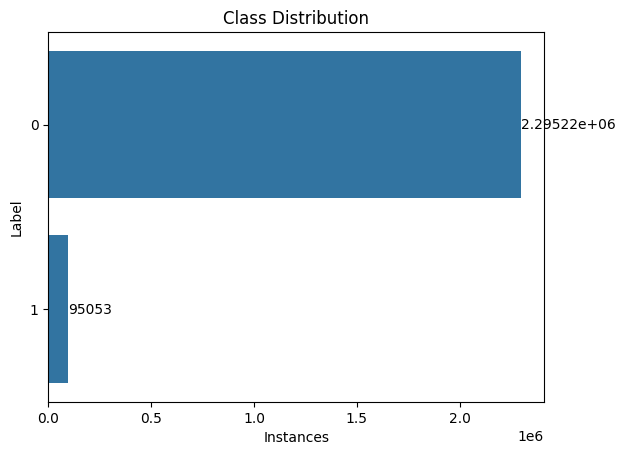

In [ ]:
#@title #### Class Distribution

ax = sns.countplot(data=data, y=TARGET, orient='h', stat="count")
ax.bar_label(ax.containers[0])
ax.set_xlabel("Instances")
ax.set_title("Class Distribution")
plt.show()

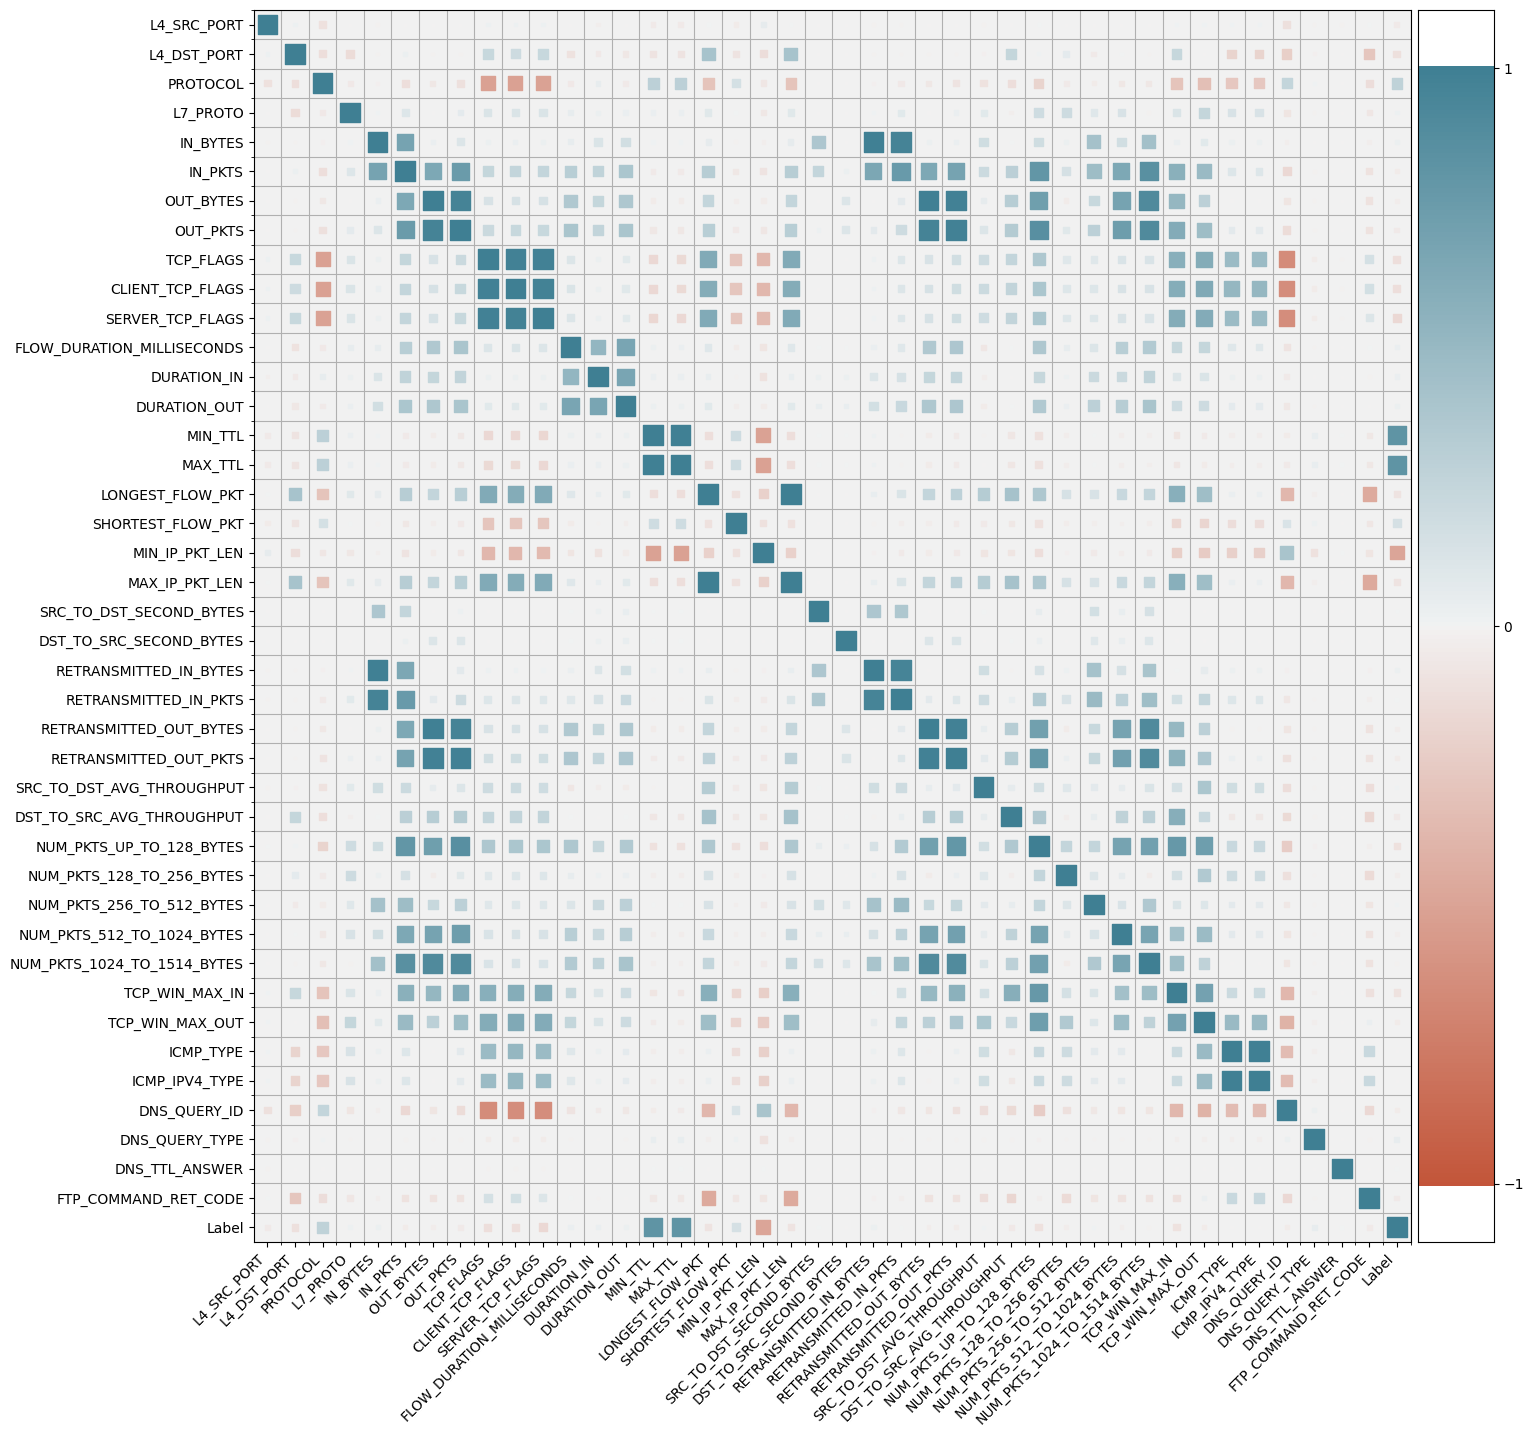

In [ ]:
#@title #### Correlation Matrix

plt.figure(figsize=(16, 16))
corrplot(data.select_dtypes(exclude=[object]).corr(), size_scale=200);

In [ ]:
#@title #### Describe
data.describe()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06,2.390275e+06
mean,3.254961e+04,1.142309e+04,9.151913e+00,3.038721e+00,4.621664e+03,3.603686e+01,3.526565e+04,4.570363e+01,1.989969e+01,1.961149e+01,1.950261e+01,2.591117e+05,1.303822e+00,1.153244e+00,3.898892e+01,3.982234e+01,7.237848e+02,5.749655e+01,5.405930e+01,7.237848e+02,1.075640e+09,4.915273e+08,1.638586e+03,5.386843e+00,1.725972e+04,1.621882e+01,2.697222e+07,9.810136e+07,5.541341e+01,1.681239e+00,1.473658e+00,1.525501e+00,2.382468e+01,1.738763e+04,1.222160e+04,1.894443e+04,7.400138e+01,4.949701e+03,2.970099e+00,2.725637e+04,3.765351e+01,3.976655e-02
std,1.916212e+04,1.853915e+04,1.101865e+01,1.358876e+01,7.021409e+04,7.995682e+01,1.565155e+05,1.174495e+02,1.113381e+01,1.105082e+01,1.108460e+01,1.022610e+06,9.848070e+00,6.716743e+00,4.102797e+01,4.098045e+01,6.161433e+02,3.748741e+01,1.191671e+01,6.161433e+02,1.050247e+12,2.108825e+11,3.507530e+04,2.726206e+01,7.809240e+04,5.491786e+01,7.296856e+07,2.374915e+08,7.869130e+01,5.364423e+00,8.451813e+00,7.028044e+00,1.114788e+02,1.693017e+04,1.097592e+04,2.037120e+04,7.957477e+01,1.378088e+04,1.240340e+02,8.958054e+06,8.430295e+01,1.954103e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,5.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.583100e+04,2.500000e+01,6.000000e+00,0.000000e+00,4.810000e+02,4.000000e+00,3.120000e+02,4.000000e+00,1.900000e+01,1.900000e+01,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,3.200000e+01,1.060000e+02,5.200000e+01,5.200000e+01,1.060000e+02,5.360000e+02,3.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.648000e+06,2.496000e+06,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.792000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.265000e+04,8.000000e+01,6.000000e+00,0.000000e+00,1.684000e+03,1.800000e+01,2.456000e+03,1.800000e+01,2.700000e+01,2.700000e+01,2.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,3.200000e+01,4.850000e+02,5.200000e+01,5.200000e+01,4.850000e+02,1.698000e+03,2.456000e+03,5.060000e+02,3.000000e+00,8.710000e+02,4.000000e+00,1.140000e+07,1.382400e+07,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.448000e+04,1.303200e+04,1.100800e+04,4.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00

In [ ]:
#@title NaN Count
data.isna().sum()

IPV4_SRC_ADDR                  0
L4_SRC_PORT                    0
IPV4_DST_ADDR                  0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_U

## Data Preprocessing

### Data Cleaning

In [ ]:
#@title #### TODO: Drop irrelevant columns

cols_to_remove = [
    "IPV4_SRC_ADDR", # Maybe encode? probably irrelevant
    "IPV4_DST_ADDR", # Maybe encode? probably irrelevant
    "Attack" # Biased towards target column
]

data.drop(columns=cols_to_remove, inplace=True)

In [ ]:
#@title #### TODO: Missing Data

# Fill Values? by mean or by most probable value

In [ ]:
#@title #### TODO: Remove Duplicates

### Data Transformation

In [ ]:
#@title #### TODO: Normalization

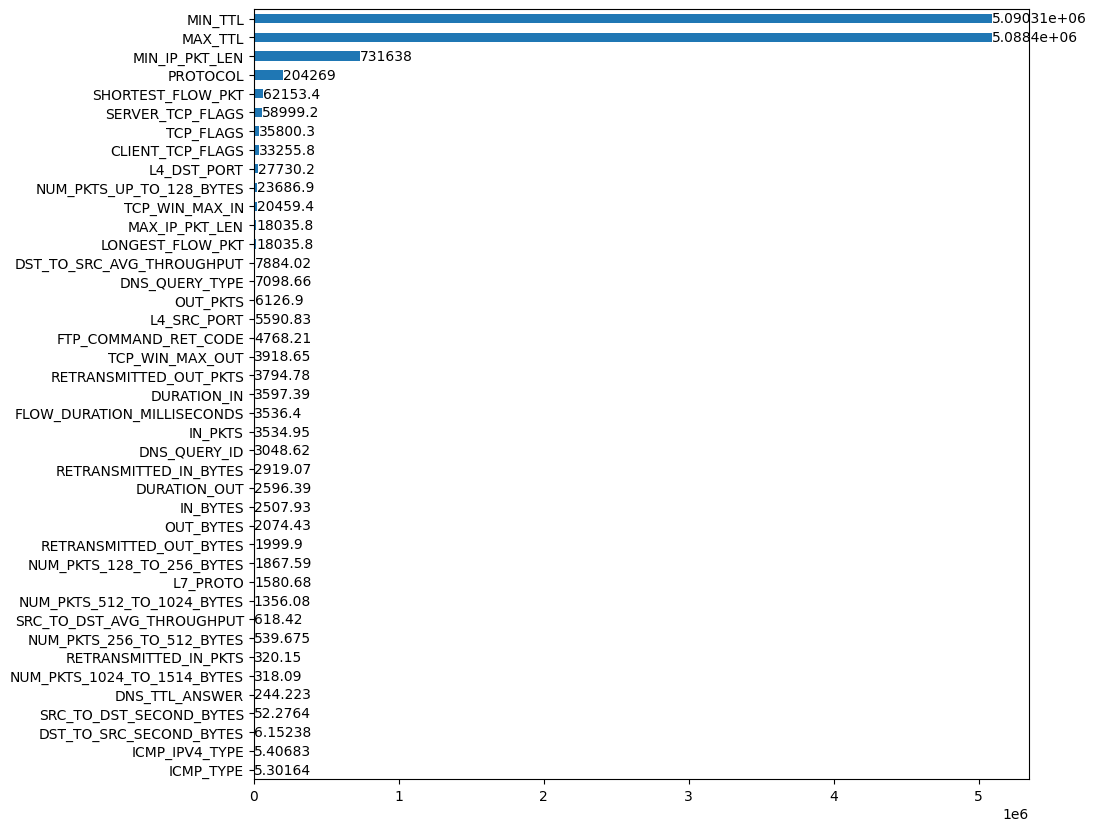

In [ ]:
#@title #### Attribute Selection - SelectKBest

temp_data = data.select_dtypes(exclude=[object])
X, y = temp_data.drop(TARGET, axis=1), temp_data[TARGET]
del temp_data

skb = SelectKBest(k=4)
skb.fit(X, y)


plt.figure(figsize=(10, 10))
importances = pd.Series(data=skb.scores_, index=X.columns.values)
ax = importances.sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.show()

selected_features = list(importances.sort_values(ascending=False).index[:4])
data = data[selected_features + [TARGET]]

In [ ]:
#@title #### TODO: Discretization

# Convert continuous value to a discrete (cut in ranges)

In [ ]:
#@title Transformed Sample
data.head()

,MIN_TTL,MAX_TTL,MIN_IP_PKT_LEN,PROTOCOL,Label
0,31,32,52,6,0
1,31,32,52,6,0
2,31,32,52,6,0
3,31,32,52,6,0
4,31,32,52,6,0


### Data Reduction

In [ ]:
#@title #### TODO: Dimensionality Reduction

## Classifiers

In [ ]:
#@title #### Train Test Split
X, y = data.drop(TARGET, axis=1), data[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_SEED, stratify=y)

del X, y

### Decision Tree

In [ ]:
#@title #### Load
if USE_DT:
    from sklearn.tree import DecisionTreeClassifier
    model = DecisionTreeClassifier()
    print("Model loaded.")

Model loaded.


In [ ]:
#@title #### Train

if USE_DT:
    if USE_GRIDSEARCH:
        parameters = [DT_ARGS]

        gs = GridSearchCV(model, parameters, cv=FOLDS, n_jobs=N_JOBS, scoring='accuracy')
        gs.fit(X_train, y_train)

        print("Melhores parâmetros encontrados:", gs.best_params_)

        # Definindo a técnica a ser utilizada
        model = gs.best_estimator_
    else:
        model.set_params(**DT_ARGS)
        model.fit(X_train, y_train)

display(model)

DecisionTreeClassifier(random_state=42)

In [ ]:
#@title #### Metrics
if USE_DT:
    if USE_CV:
        score = model_selection.cross_val_score(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        y_pred = model_selection.cross_val_predict(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        ema = metrics.mean_absolute_error(y_test, y_pred)

        print(f"Acurácia média {FOLDS} folds:", score.mean())
        print("Desvio Padrão:", score.std())
        print("Erro médio absoluto:", ema)
    else:
        y_pred = model.predict(X_test)
        acc = metrics.accuracy_score(y_test, y_pred)
        ema = metrics.mean_absolute_error(y_test, y_pred)

        print(f"Acurácia:", acc)
        print("Erro médio absoluto:", ema)


Acurácia: 0.9934338099172689
Erro médio absoluto: 0.006566190082731066


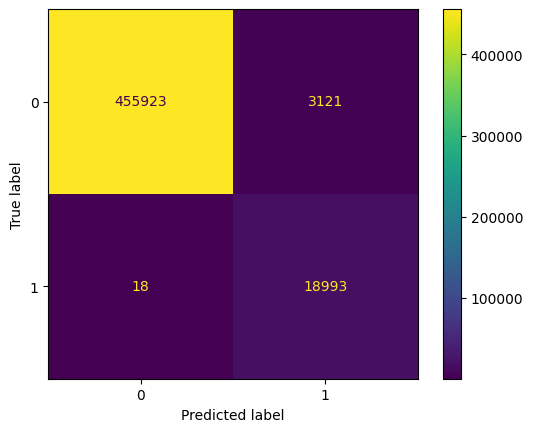

In [ ]:
#@title #### Confusion Matrix

if USE_DT:
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=range(target_names.size))
    cmp.plot()

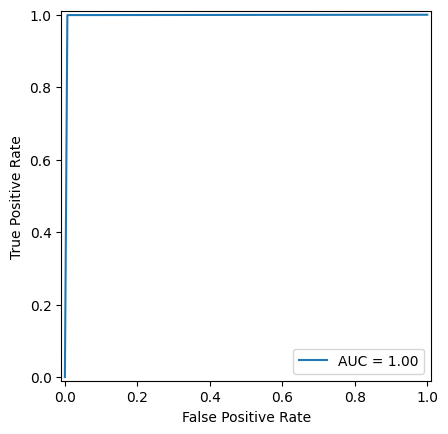

In [ ]:
#@title #### ROC Curve

if USE_DT:
    plot_ROC(y_test, y_pred)

### Naive Bayes

In [ ]:
#@title #### Load

if USE_NB:
    from sklearn.naive_bayes import GaussianNB
    model = GaussianNB()
    print("Model loaded.")

Model loaded.


In [ ]:
#@title #### Train

if USE_NB:
    if USE_GRIDSEARCH:
        parameters = [NB_ARGS]

        gs = GridSearchCV(model, parameters, cv=FOLDS, n_jobs=N_JOBS, scoring='accuracy')
        gs.fit(X_train, y_train)

        print("Melhores parâmetros encontrados:", gs.best_params_)

        # Definindo a técnica a ser utilizada
        model = gs.best_estimator_
    else:
        model.set_params(**NB_ARGS)
        model.fit(X_train, y_train)

display(model)

GaussianNB()

In [ ]:
#@title #### Metrics
if USE_NB:
    if USE_CV:
        score = model_selection.cross_val_score(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        y_pred = model_selection.cross_val_predict(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        ema = metrics.mean_absolute_error(y_test, y_pred)

        print(f"Acurácia média {FOLDS} folds:", score.mean())
        print("Desvio Padrão:", score.std())
        print("Erro médio absoluto:", ema)
    else:
        y_pred = model.predict(X_test)
        acc = metrics.accuracy_score(y_test, y_pred)
        ema = metrics.mean_absolute_error(y_test, y_pred)

        print(f"Acurácia:", acc)
        print("Erro médio absoluto:", ema)


Acurácia: 0.9792555249918943
Erro médio absoluto: 0.02074447500810576


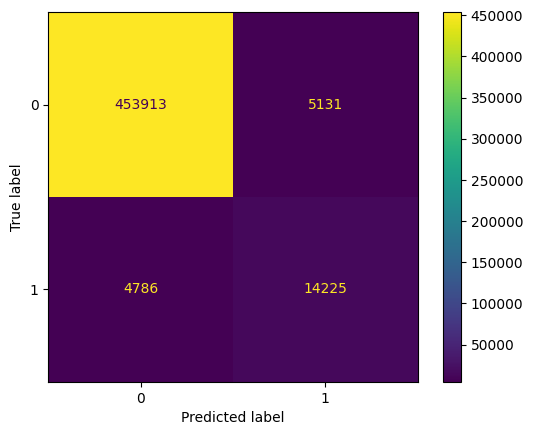

In [ ]:
#@title #### Confusion Matrix
if USE_NB:
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=range(target_names.size))
    cmp.plot()

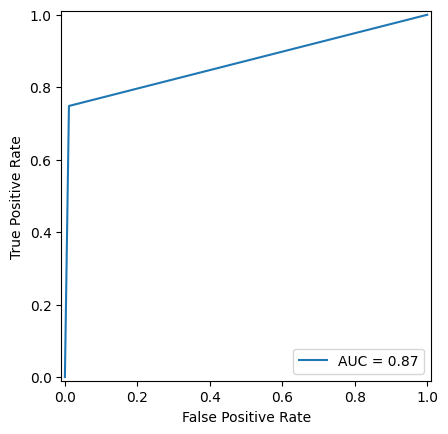

In [ ]:
#@title #### ROC Curve
if USE_NB:
    plot_ROC(y_test, y_pred)

### KNN

In [ ]:
#@title #### Load

if USE_KNN:
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier()
    print("Model loaded.")

Model loaded.


In [ ]:
#@title #### Train

if USE_KNN:
    if USE_GRIDSEARCH:
        parameters = [KNN_ARGS]

        gs = GridSearchCV(model, parameters, cv=FOLDS, n_jobs=N_JOBS, scoring='accuracy')
        gs.fit(X_train, y_train)

        print("Melhores parâmetros encontrados:", gs.best_params_)

        # Definindo a técnica a ser utilizada
        model = gs.best_estimator_
    else:
        model.set_params(**KNN_ARGS)
        model.fit(X_train, y_train)

display(model)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#@title #### Metrics
if USE_KNN:
    if USE_CV:
        score = model_selection.cross_val_score(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        y_pred = model_selection.cross_val_predict(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        ema = metrics.mean_absolute_error(y_test, y_pred)

        print(f"Acurácia média {FOLDS} folds:", score.mean())
        print("Desvio Padrão:", score.std())
        print("Erro médio absoluto:", ema)
    else:
        print("Non-CV")
        print("Predicted")
        print("Accuracy")

        print(f"Acurácia:", acc)
        print("Erro médio absoluto:", ema)


Non-CV
Predicted
Accuracy
Acurácia: 0.983290625555637
Erro médio absoluto: 0.016709374444363097


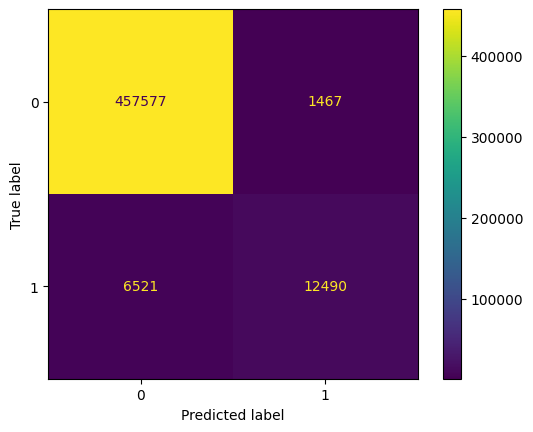

In [ ]:
#@title #### Confusion Matrix
if USE_KNN:
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=range(target_names.size))
    cmp.plot()

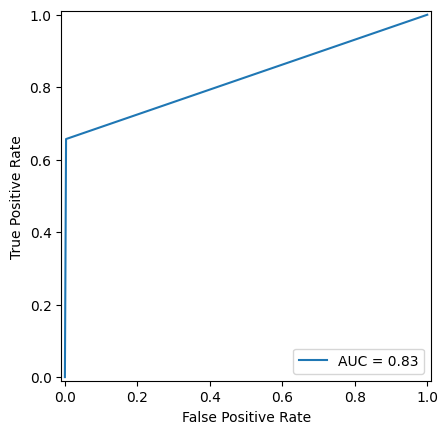

In [ ]:
#@title #### ROC Curve
if USE_KNN:
    plot_ROC(y_test, y_pred)

### SVM

In [ ]:
#@title #### Load

if USE_SVM:
    from sklearn.svm import SVC
    model = SVC()
    print("Model loaded.")

Model loaded.


In [ ]:
#@title #### Train

if USE_SVM:
    if USE_GRIDSEARCH:
        parameters = [SVM_ARGS]

        gs = GridSearchCV(model, parameters, cv=FOLDS, n_jobs=N_JOBS, scoring='accuracy')
        gs.fit(X_train, y_train)

        print("Melhores parâmetros encontrados:", gs.best_params_)

        # Definindo a técnica a ser utilizada
        model = gs.best_estimator_
    else:
        model.set_params(**SVM_ARGS)
        model.fit(X_train, y_train)

display(model)

SVC(random_state=42)

In [ ]:
#@title #### Metrics
if USE_DT:
    if USE_CV:
        score = model_selection.cross_val_score(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        y_pred = model_selection.cross_val_predict(model, X_test, y_test, cv=FOLDS, n_jobs=N_JOBS)
        ema = metrics.mean_absolute_error(y_test, y_pred)

        print(f"Acurácia média {FOLDS} folds:", score.mean())
        print("Desvio Padrão:", score.std())
        print("Erro médio absoluto:", ema)
    else:
        y_pred = model.predict(X_test)
        acc = metrics.accuracy_score(y_test, y_pred)
        ema = metrics.mean_absolute_error(y_test, y_pred)

        print(f"Acurácia:", acc)
        print("Erro médio absoluto:", ema)

Acurácia: 0.9926619322044534
Erro médio absoluto: 0.007338067795546538


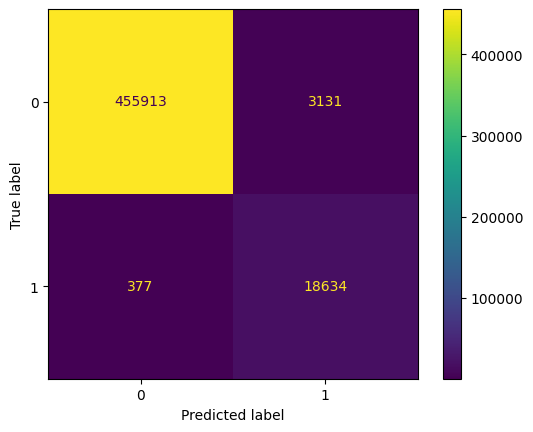

In [ ]:
#@title #### Confusion Matrix
if USE_SVM:
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=range(target_names.size))
    cmp.plot()

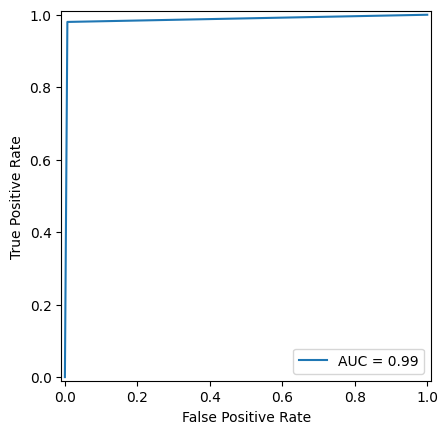

In [ ]:
#@title #### ROC Curve
if USE_SVM:
    plot_ROC(y_test, y_pred)

#Relatório Dataset -  NF-UNSW-NB15-v2
Informações dataset -> 2390275 instâncias e 44 features


Classificadores utilizaram modelo preditivo e foram divididos em 80% treino e 20% teste

##Desempenho:

- Árvore de decisão (random_state=42):

Acurácia: 0.9934338099172689 | Erro médio absoluto: 0.006566190082731066

- KNN (n_neighbors=3):

Acurácia: 0.983290625555637 | Erro médio absoluto: 0.016709374444363097

- SVM (random_state=42):

Acurácia: 0.9926619322044534 | Erro médio absoluto: 0.007338067795546538

- Naive Bayes:

Acurácia: 0.9792555249918943 | Erro médio absoluto: 0.02074447500810576

##Conclusão:
Levando em consideração o desempenho dos classificadores e dificuldade de implementa-los, a árvore de decisão se mostrou o melhor classificador para o dataset em questão.
